In [1]:
import numpy as np
from typing import List, Dict
from scipy.special import softmax
import matplotlib.pyplot as plt

# 1. Illustration of the decoding of the embedding values

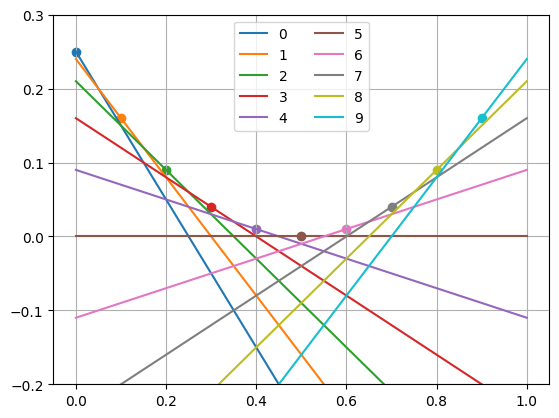

In [2]:
xs = np.linspace(0, 1, 20)
for j in range(10):
  plt.plot(xs, (0.25 - ((j)/10)**2) + (2*(j)/10 -1) * xs, label=str(j) )
  plt.scatter((j)/10, (0.25 - ((j)/10)**2) + (2*(j)/10 -1) * (j)/10 )

plt.legend(ncol=2)
plt.grid()
plt.ylim(-.2, .3)

# 2. Unconditional generation controlling only the first embedding

In [3]:
# we use the ASCII encoding for the 94 printable ASCII characters as our tokenizer

N = 20 # max sequence length
V = 94 # vocabulary size
T = 50 # softmax (inverse) temperature

def char_to_onehot_token(c: str):
  assert len(c)==1
  r = np.zeros(V)
  r[ord(c[0])-32] = 1
  return r

def pred_vector_to_char(arr: np.array):
  return chr(np.argmax(arr)+32)

def build_virtual_token(s: str):
  """ Given a string s, this builds its encoding as an embedding """
  assert len(s) <= N
  r = np.zeros(N)
  s = s.ljust(N, ' ') # padding so that all sequences are N long, this way no need for a special EOS token
  for i, c in enumerate(s):
    r[i] = (ord(c)-32)/V
  return r

def position_encoding(i: int):
  r = np.zeros(N)
  r[i] = 1
  return r

def attention_head(WQ, WK, WV, xs):
  qs = [WQ @ x for x in xs]
  ks = [WK @ x for x in xs]
  vs = [WV @ x for x in xs]

  A = np.zeros((len(xs), len(xs)))
  for i in range(len(xs)):
    for j in range(len(xs)):
      A[i, j] = (np.dot(qs[i],ks[j])) / np.sqrt(len(xs))

  A = softmax(A*T, axis=1)
  # print(np.round(A, 3))

  r = []
  for i in range(len(xs)):
    rr = np.zeros_like(vs[0])
    for j in range(len(xs)):
      rr += A[i, j] * vs[j]
    r.append(rr)

  return r

def linear_layer(A, b, xs, with_relu=True):
  rs = [np.dot(A, x) + b for x in xs]
  if with_relu:
    rs = [np.clip(r, 0, np.inf) for r in rs]
  return rs

In [4]:
target_string = "I love transformers!"

E = np.zeros((N, V)) # embedding matrix, it's value doesn't matter in this case

x = np.hstack([build_virtual_token(target_string), position_encoding(0)])

y = []

while len(y) < N:

  input = [x] + [np.hstack([E @ char_to_onehot_token(y[i]), position_encoding(i+1)]) for i in range(len(y))]

  K_pos = Q_pos = V_pos =  np.block([[np.zeros((N, N)), np.eye(N)]])
  h_pos = attention_head(Q_pos, K_pos, V_pos, input)

  K_first = np.zeros((1, 2*N))
  K_first[0, N] = 1

  Q_first = np.concatenate([np.zeros(N), np.ones(N)])

  V_first = np.block([[np.eye(N), np.zeros((N, N))]])

  h_first = attention_head(Q_first, K_first, V_first, input)

  h = [p+f for p, f in zip(h_pos, h_first)]

  A1 = np.eye(N)
  b1 = np.ones(N) * -1
  z1 = linear_layer(A1, b1, h)

  A2 = np.ones(N)
  b2 = 0
  z2 = linear_layer(A2, b2, z1)

  A3 = np.zeros(V)
  b3 = np.zeros(V)
  for i in range(V):
    A3[i] = 2*i/V - 1
    b3[i] = 0.25 - (i/V)**2

  y = linear_layer(A3, b3, z2, with_relu=False)
  y = [pred_vector_to_char(yy) for yy in y]

  print("".join(y))


I
I 
I l
I lo
I lov
I love
I love 
I love t
I love tr
I love tra
I love tran
I love trans
I love transf
I love transfo
I love transfor
I love transform
I love transforme
I love transformer
I love transformers
I love transformers!


# 3. Conditional generation of a single token given a single token

In [5]:
V = 94 # vocabulary size
N = 2 # max sequence length
T = 100 # softmax (inverse) temperature

def build_virtual_token(m: Dict):
  """ Given a map m from charcters to characters, this builds it encoding as an embedding """
  r = np.zeros(V)
  for i in range(94):
    key_char = chr(i+32)
    if key_char in m:
      r[i] = (ord(m[key_char]) - 32) / V
    else:
      r[i] = 0 / V
  return r



In [6]:
# flip the case of the letter
m = {**dict(zip("abcdefghijklmnopqrstuvwxyz", "ABCDEFGHIJKLMNOPQRSTUVWXYZ")),
     **dict(zip("ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz"))}

user_character = "f"

E = np.eye(V) # embedding matrix

x = [
    np.hstack([build_virtual_token(m), position_encoding(0)]),
    np.hstack([E @ char_to_onehot_token(user_character), position_encoding(1)]),
]

K_val = Q_val = np.block([[np.zeros((N, V)), np.eye(N)]])
V_val = np.block([[np.eye(V), np.zeros((V,N))]])
h_val = attention_head(Q_val, K_val, V_val, x)

K_first = np.zeros((1, V+N))
K_first[0, V] = 1

Q_first = np.concatenate([np.zeros(V), np.ones(N)])

V_first = np.block([[np.eye(V), np.zeros((V, N))]])

h_first = attention_head(Q_first, K_first, V_first, x)

h = [p+f for p, f in zip(h_val, h_first)]

A1 = np.eye(V)
b1 = np.ones(V) * -1
z1 = linear_layer(A1, b1, h)

A2 = np.ones(V)
b2 = 0
z2 = linear_layer(A2, b2, z1)

A3 = np.zeros(V)
b3 = np.zeros(V)
for i in range(V):
  A3[i] = 2*i/V - 1
  b3[i] = 0.25 - (i/V)**2

y = linear_layer(A3, b3, z2, with_relu=False)
y = [pred_vector_to_char(yy) for yy in y]

print(f"User input: {user_character}, model response: {y[1]}")

User input: f, model response: F


# 4. Conditional generation with longer responses

In [7]:
V = 94 # vocabulary size
N0 = 10 # response length
N = 2*N0 # max sequence length
T = 100 # softmax (inverse) temperature

def build_virtual_tokens(m: Dict):
  """ Given a map m from charcters to strings, this builds it encoding as an embedding """

  # pad m with spaces so that all targets are equally long
  max_target_len = max([len(v) for v in m.values()])
  if max_target_len > N0:
    raise RuntimeError(f"The longest target ({max_target_len}) is longer than the response length ({N0})!")
  padded_m = {k: v.ljust(N0, ' ') for k,v in m.items()}

  vts = []

  for pos in range(N0):
    r = np.zeros(V)
    for i in range(94):
      key_char = chr(i+32)
      if key_char in m:
        r[i] = (ord(padded_m[key_char][pos]) - 32) / V
      else:
        r[i] = 0 / V
    vts.append(r)

  return vts


In [8]:
# Complete capital letters with animals and small letters with food
m = {
  "A": "lligator",
  "B": "ear",
  "C": "at",
  "D": "og",
  "E": "lephant",
  "F": "lamingo",
  "G": "irafe",
  "H": "ippo",
  "I": "guana",
  "J": "aguar",
  "K": "oala",
  "L": "ion",
  "M": "onkey",
  "N": "ewt",
  "O": "strich",
  "P": "ig",
  "Q": "uail",
  "R": "hino",
  "S": "heep",
  "T": "iger",
  "U": "rchin",
  "V": "ulture",
  "W": "olf",
  "X": "ray tetra",
  "Y": "ak",
  "Z": "ebra",
  "a": "sparagus",
  "b": "lueberries",
  "c": "auliflower",
  "d": "aikon",
  "e": "ndive",
  "f": "ig",
  "g": "inger",
  "h": "oney",
  "i": "ce cream",
  "j": "am",
  "k": "iwi",
  "l": "emon",
  "m": "ango",
  "n": "ettle",
  "o": "kra",
  "p": "each",
  "q": "uinoa",
  "r": "adish",
  "s": "pinach",
  "t": "urnips",
  "u": "meboshi",
  "v": "ine leaf",
  "w": "atermelon",
  "x": "ylitol",
  "y": "am",
  "z": "ucchini",
}



In [9]:
user_character = "b"

E = np.eye(V) # embedding matrix

vts = build_virtual_tokens(m)

y = [user_character]

while len(y) <= N0:

  # print(f"y={y}")
  # if len(y) > 3:
  #   break

  x = [np.hstack([vts[i], position_encoding(i)]) for i in range(N0) ] + [np.hstack([E @ char_to_onehot_token(gen_char), position_encoding(N0+i)]) for i, gen_char in enumerate(y)]

  # gets the value N0 positions back
  Q_N0back = np.block([
      [np.zeros((N0, V)), np.zeros((N0, N0)), np.eye(N0)],
      [np.zeros((N0, V)), np.zeros((N0, N0)), np.zeros((N0, N0))],
    ])
  K_N0back = np.block([np.zeros((N, V)), np.eye(N)])
  V_N0back = np.block([[np.eye(V), np.zeros((V, N))]])
  h_N0back = attention_head(Q_N0back, K_N0back, V_N0back, x)

  # always gets the value of the user-provided token
  Q_user = np.concatenate([np.zeros(V), np.ones(N)])
  K_user = np.concatenate([np.zeros(V), np.zeros(N0), [1], np.zeros(N0-1)])
  V_user = np.block([[np.eye(V), np.zeros((V,N))]])
  h_user = attention_head(Q_user, K_user, V_user, x)

  h = [p+f for p, f in zip(h_user, h_N0back)]

  A1 = np.eye(V)
  b1 = np.ones(V) * -1
  z1 = linear_layer(A1, b1, h)

  A2 = np.ones(V)
  b2 = 0
  z2 = linear_layer(A2, b2, z1)

  A3 = np.zeros(V)
  b3 = np.zeros(V)
  for i in range(V):
    A3[i] = 2*i/V - 1
    b3[i] = 0.25 - (i/V)**2

  out = linear_layer(A3, b3, z2, with_relu=False)
  next_char = pred_vector_to_char(out[-1])
  y.append(next_char)

  print("".join(y))

bl
blu
blue
blueb
bluebe
blueber
blueberr
blueberri
blueberrie
blueberries


# 5. Conditional generation given 2 tokens

In [10]:
V = 10 # vocabulary size (restricted only to first 10 capital letters to prevent numerical issues)
N = 4 # max sequence length
T = 1000 # softmax (inverse) temperature

def seq_to_float(seq):
  """Encodes a sequence to a float in [0, 1)"""
  assert len(seq) == V
  powers = [V**(V-i) for i in range(V)]
  return sum([v*p for v, p in zip(seq, powers)])/(V**V)

def float_to_seq(num):
  """Decodes a float in [0, 1) to a sequenze"""
  reverse = []
  num *= V**V
  if num == 0:
    return [0]*V
  while num > 0:
    reverse.append((num%V)/V)
    num = num//V
  l = list(reversed(reverse))
  return [0] * (V-len(l)) + l

def build_virtual_token(m: Dict):
  """ Given a map m from strings of length 2 to characters, this builds it encoding as an embedding """
  r = np.zeros(V)
  for i in range(V):
    key_char = chr(i+65)

    # build the map for the second position
    m2 = {s[1]: v for s, v in m.items() if s[0]==key_char}

    # encode this map as a value between 0 and 1
    r2 = np.zeros(V)
    for j in range(V):
      if chr(j+65) in m2:
        r2[j] = (ord(m2[chr(j+65)]) - 65) / V
      else:
        r2[j] = (30+65) / V # corresponds to "_"

    r[i] = seq_to_float(r2)
    if key_char == "q":
      print(r[i], r2)
  return r

def char_to_onehot_token(c: str):
  assert len(c)==1
  r = np.zeros(V)
  r[ord(c[0])-65] = 1
  return r

def pred_vector_to_char(arr: np.array):
  return chr(np.argmax(arr)+65)

In [11]:
# This map just returns the second character:
# m = {chr(i+65)+chr(j+65): chr(j+65) for i in range(V) for j in range(V) }
# This is a random map:
np.random.seed(0)
m = {chr(i+65)+chr(j+65): chr(np.random.randint(V)+65) for i in range(V) for j in range(V) }


print("Test sequences:")
ts = ["AB", "AA", "BA", "DE", "BB", "BG"]
for t in ts:
  print(f"'{t}' -> '{m[t]}'")

Test sequences:
'AB' -> 'A'
'AA' -> 'F'
'BA' -> 'H'
'DE' -> 'D'
'BB' -> 'G'
'BG' -> 'H'


In [12]:
def compute_completion(m, user_input):

  E = np.eye(V) # embedding matrix
  vt = build_virtual_token(m)
  x = [
      np.hstack([np.zeros_like(vt), position_encoding(0)]), # a dummy virtual tokens with only zeros to attend to when we don't want to attend to anything
      np.hstack([vt, position_encoding(1)]),
      np.hstack([E @ char_to_onehot_token(user_input[0]), position_encoding(2)]),
      np.hstack([E @ char_to_onehot_token(user_input[1]), position_encoding(3)]),
  ]

  # extract the value of the first user-provided token but only if we are
  # currently computing that position and put
  # it in the first half of the residual stream
  Q_user_token1 = np.block([np.zeros((2, V)), np.array([[1,1,0,1],[0,0,1,0]])])
  K_user_token1 = np.block([np.zeros((2, V)), np.array([[1,0,0,0],[0,0,1,0]])])
  # this V matrix copies only in the first half of the residual stream
  V_user_token1 = np.block([
      [np.eye(V), np.zeros((V, N))],
      [np.zeros((V,V)), np.zeros((V, N))],
  ])
  h_user_token1 = attention_head(Q_user_token1, K_user_token1, V_user_token1, x)

  # same for the second token when we are looking at the second position
  Q_user_token2 = np.block([np.zeros((2, V)), np.array([[1,1,1,0],[0,0,0,1]])])
  K_user_token2 = np.block([np.zeros((2, V)), np.array([[1,0,0,0],[0,0,0,1]])])
  # this V matrix copies only in the second half of the residual stream
  V_user_token2 = np.block([
      [np.zeros((V,V)), np.zeros((V, N))],
      [2*np.eye(V), np.zeros((V, N))], #2 times so that it becomes 1 when we substract 1 in the following linear layer
  ])
  h_user_token2 = attention_head(Q_user_token2, K_user_token2, V_user_token2, x)

  # place the prefix in the first half of the residual stream as well
  # this way the first user input token will bump the prefix value at
  # the corresponding position to be above 1
  Q_first = np.block([np.zeros((2, V)), np.array([[1,1,0,1],[0,0,1,0]])])
  K_first = np.block([np.zeros((2, V)), np.array([[1,0,0,0],[0,1,0,0]])])
  V_first = V_user_token1
  h_first = attention_head(Q_first, K_first, V_first, x)

  # combine the heads
  h1 = [u1+u2+f for u1, u2, f in zip(h_user_token1, h_user_token2, h_first)]

  # we want to now extract the value for the map from
  # second user token to response token
  # we do that as before: substract 1 from everything and ReLU it
  # however, we have to be careful to

  A1_1 = np.eye(V*2)
  b1_1 = np.ones(V*2) * -1
  z1_1 = linear_layer(A1_1, b1_1, h1)

  # and now we want to unpack the one non-zero value in the first
  # half of the residual stream to V values according to the float_to_seq function
  # we are going to save ourselves the hassle of building an explicit MLP for that
  # and will use Python functions instead

  z1_2 = [np.hstack((float_to_seq(np.sum(z1_1[i][:V])), z1_1[i][V:])) for i in range(N)]

  # and now the second attention layer combines the newly unpacked embedding in
  # the first half of the residual stream with the second user-provided token
  # this is almost the same as the case with conditioning on one token, with
  # the only difference that now our residual stream is twice as wide

  Q_embedding = np.block([np.zeros(V), np.ones(V)])
  K_embedding = np.block([np.ones(V), np.zeros(V)])
  V_embedding = np.block([
      [np.eye(V), np.zeros((V,V))],
      ])
  h_embedding = attention_head(Q_embedding, K_embedding, V_embedding, z1_2)

  K_user_token2_remap = np.block([np.zeros(V), np.ones(V)])
  Q_user_token2_remap = np.block([np.zeros(V), np.ones(V)])
  V_user_token2_remap = np.block([
      [np.zeros((V,V)), np.eye(V)],
      ])
  h_user_token2_remap = attention_head(Q_user_token2_remap, K_user_token2_remap, V_user_token2_remap, z1_2)

  h2 = [e+t for e, t in zip(h_embedding, h_user_token2_remap)]

  # Now decode as usual: substract 1, ReLU, and map to an output token
  A2_1 = np.eye(V)
  b2_1 = np.ones(V) * -1
  z2_1 = linear_layer(A2_1, b2_1, h2)

  A2_2 = np.ones(V)
  b2_2 = 0
  z2_2 = linear_layer(A2_2, b2_2, z2_1)

  A2_3 = np.zeros(V)
  b2_3 = np.zeros(V)
  for i in range(V):
    A2_3[i] = 2*i/V - 1
    b2_3[i] = 0.25 - (i/V)**2

  y_ = linear_layer(A2_3, b2_3, z2_2, with_relu=False)
  y = [pred_vector_to_char(yy) for yy in y_]
  return y


In [13]:
user_input = "BG"
y = compute_completion(m, user_input)
print(f"User input: {user_input}, model response: {y[3]} (ground truth is {m[user_input]})")

User input: BG, model response: H (ground truth is H)


In [14]:
# test all:
correct = []
for k, v in m.items():
  y = compute_completion(m, k)[3]
  correct.append(y==v)
  if y!=v:
    print(f"DIFFERENCE: For user input {k} we get completion {y} when we expected {v}!")
print(f"Correctly completed sequences: {100*sum(correct)/len(correct):.2f}%")
# It is possible that we get a few errors because of numerical issues:
# a change in the embedding of as little as 1e-10 (1/(V^V)) changes the map!

Correctly completed sequences: 100.00%
